In [9]:
import numpy as np
from poisson import Poisson

class PolicyIterationSolver(object):
# maximum # of bikes in each location
    capacity = 20
# credit earned by a bike
    rental_reward = 10
# cost of moving a bike
    moving_cost = 1
# maximum # of bikes to move during night
    max_moving = 5
# The cost of an illegal 'move'.
    bad_action_cost = 100
# expectation for rental requests in first location
    request_mean_G1 = 3
# expectation for rental requests in second location
    request_mean_G2 = 3
# expectation for # of bikes returned in first location
    return_mean_G1 = 3
# expectation for # of bikes returned in second location
    return_mean_G2 = 2
# The future value of money (i.e., tomorrow's money is today worth DISCOUNT_RATE*(what it is worth tomorrow))
    discount = 0.9
    

In [ ]:
  PolicyEvaluationError = 0.01

    policy = None
    value = None

    def __init__(self):
        self.policy = np.zeros([self.capacity + 1]*2, int)
        self.value = np.zeros([self.capacity + 1]*2)

        self._reward1 = self.expected_rental_reward(self.request_mean_G1)
        self._reward2 = self.expected_rental_reward(self.request_mean_G2)

        assert self.bad_action_cost >= 0

    def bellman(self, action, s1, s2):
        transp1 = self.transition_probabilty(s1, self.request_mean_G1, self.return_mean_G1, -action)
        transp2 = self.transition_probabilty(s2, self.request_mean_G2, self.return_mean_G2, action)
        transp = np.outer(transp1, transp2)

        return self._reward1[s1] + self._reward2[s2] - self.expected_moving_cost(s1, s2, action) + \
               self.discount * sum((transp * self.value).flat)

In [ ]:
 # policy evaluation
    def policy_evaluation(self):
        ''' Keep pocliy fixed and update value. '''
        while True:
            diff = 0.
            it = np.nditer([self.policy], flags=['multi_index'])

            while not it.finished:
                action = it[0]
                s1, s2 = it.multi_index

                _temp = self.value[s1, s2]

                self.value[s1, s2] = self.bellman(action=action, s1=s1, s2=s2)

                diff = max(diff, abs(self.value[s1, s2] - _temp))

                it.iternext()

            print(diff)
            if diff < self.PolicyEvaluationError:
                break

In [ ]:
 def policy_update(self):
        is_policy_changed = False

        it = np.nditer([self.policy], flags=['multi_index'])
        while not it.finished:
            s1, s2 = it.multi_index

            _max_val = -1
            _pol = None

            for act in range(-self.max_moving, self.max_moving + 1):
                _val = self.bellman(action=act, s1=s1, s2=s2)
                if _val > _max_val:
                    _max_val = _val
                    _pol = act

            if self.policy[s1, s2] != _pol:
                is_policy_changed = True
                self.policy[s1, s2] = _pol

            it.iternext()

        return is_policy_changed


In [ ]:
def expected_moving_cost(self, s1, s2, action):
        if action == 0:
            return 0.

        # moving from state s1 into state s2
        if action > 0:
            p = self.transition_probabilty(s1, self.request_mean_G1, self.return_mean_G1)
            cost = self._gen_move_cost_array(action)
            return cost.dot(p)

        # moving from state s2 into state s1
        p = self.transition_probabilty(s2, self.request_mean_G2, self.return_mean_G2)
        cost = self._gen_move_cost_array(action)
        return cost.dot(p)

In [ ]:
# Generate an array based on which costs of move is calculated.

def _gen_move_cost_array(self, action):
        _action = abs(action)

        # Don't punish bad action:
        if self.bad_action_cost == 0:
            cost = np.asarray(
                [ii if ii < _action else _action for ii in range(self.capacity+1)]
            ) * self.moving_cost

        # bad action is punished
        else:
            cost = np.asarray(
                [self.bad_action_cost if ii < _action else _action for ii in range(self.capacity + 1)]
            ) * self.moving_cost
        return cost

In [ ]:
    def expected_rental_reward(cls, expected_request):
        return np.asarray([cls._state_reward(s, expected_request) for s in range(cls.capacity + 1)])

    @classmethod
    def _state_reward(cls, s, mu):
        rewards = cls.rental_reward * np.arange(s + 1)
        p = Poisson.pmf_series(mu, cutoff=s)
        return rewards.dot(p)

    def transition_probabilty(self, s, req, ret, action=0):
        '''    
        :param s: Current State
        :param req: Mean value of requests
        :param ret: Mean value of returns
        :param action: Action. Positive means move in. Negative means move out.
        :return: Transition probability.
        '''

        _ret_sz = self.max_moving + self.capacity

        p_req = Poisson.pmf_series(req, s)
        p_ret = Poisson.pmf_series(ret, _ret_sz)
        p = np.outer(p_req, p_ret)

        transp = np.asarray([p.trace(offset) for offset in range(-s, _ret_sz + 1)])

        assert abs(action) <= self.max_moving, "action can be large than %s." % self.max_moving

        # No cars are being moved
        if action == 0:
            transp[20] += sum(transp[21:])
            return transp[:21]

        # Move cars from Garage 1 to Garage 2
        if action > 0:
            transp[self.capacity-action] += sum(transp[self.capacity-action+1:])
            transp[self.capacity-action+1:] = 0

            return np.roll(transp, shift=action)[:self.capacity+1]

        # Move cars from Garage 2 to Garage 1
        action = -action
        transp[action] += sum(transp[:action])
        transp[:action] = 0

        transp[action+self.capacity] += sum(transp[action+self.capacity+1:])
        transp[action+self.capacity+1:] = 0

        return np.roll(transp, shift=-action)[:self.capacity+1]


146.73034356959874
107.17354021108113
80.27937468215148
61.87463790584064
50.57760520894132
42.16108252598224
34.73231868831226
28.451821895365867
23.256628652449876
19.003502330645176
15.537096817571069
12.911637068808773
10.788290079174828
8.994337700230574
7.48390159474684
6.216194586723361
5.155244379306566
4.269581224537433
3.531893146231255
2.9186528253225674
2.4097286668376796
1.9879957018842447
1.6389603506282242
1.3504093368356962
1.1120890571262976
0.9154183359884769
0.7532349906167042
0.6195749394148038
0.5094815593615181
0.41884245863525393
0.34425063265291556
0.2828869959781173
0.2324214431399696
0.19092982695315186
0.15682451226439298
0.12879643954119047
0.1057668995650829
0.08684746862195425
0.07130677793713858
0.05854299048110079
0.04806103249023863
0.03945377805729322
0.03238651449942154
0.02658412647554087
0.0218205302393244
0.01790996808165346
0.014699839149386662
0.012064798116455222
0.009901899407338988
40.66896314147118
2.1765244532235215
1.2396002343235182
0.9631

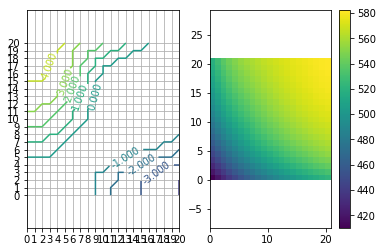

In [8]:

    def policy_iteration(self):
        '''
        Caveat: the situation where the policy continually switches between two or more policies that are equally good is not considered yet. 
        :return: 
        '''
        self.policy_evaluation()
        while self.policy_update():
            self.policy_evaluation()


if __name__ == '__main__':

    solver = PolicyIterationSolver()

    for ii in range(4):
        solver.policy_evaluation()
        solver.policy_update()

    print(solver.policy)

    import matplotlib.pylab as plt

    plt.subplot(121)
    CS = plt.contour(solver.policy, levels=range(-6, 6))
    plt.clabel(CS)
    plt.xlim([0, 20])
    plt.ylim([0, 20])
    plt.axis('equal')
    plt.xticks(range(21))
    plt.yticks(range(21))
    plt.grid('on')

    plt.subplot(122)
    plt.pcolor(solver.value)
    plt.colorbar()
    plt.axis('equal')

    plt.show()

